In [ ]:
# at least 2 convolution layers
# at least 2 FC layers before output
# have to use softmax
# use softmax cross-entropy loss when optimizing
# use early stopping to avoid overfitting

# Written by Ashley Dowd

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from random import shuffle

import pandas as pd
from random import *
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
len(test_Y)

10000

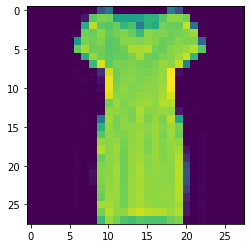

In [ ]:
plt.imshow(train_X[20])

In [ ]:
train_X[0].shape

(28, 28)

In [ ]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [ ]:
yTrainOneHot = np.zeros((60000, 10))
for idx, y in enumerate(train_Y):
  yTrainOneHot[idx][y] = 1

yTestOneHot = np.zeros((10000, 10))
for idx, y in enumerate(test_Y):
  yTestOneHot[idx][y] = 1

In [ ]:
def add_weights(shape):
  #create weight connections for all the layers
  return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [ ]:
def biasl(shape):
  #create biases for all the connections
  return tf.Variable(tf.constant(0.05, shape=shape))

In [ ]:
def conv_layer(prev_layer, kernel, input_shape, output_shape, stride):
  #create the convolution layers with the weights
  weights = add_weights([kernel, kernel, input_shape, output_shape])
  bias = biasl([output_shape])
  stride = [1, stride, stride, 1]
  c_layer = tf.nn.conv2d(prev_layer, weights, stride, padding='SAME') + bias
  return c_layer

In [ ]:
def pooling_layer(c_layer, size, stride_s):
  #create the max pooling layer
  kernel = [1, size, size, 1]
  stride = [1, stride_s, stride_s, 1]
  p_layer = tf.nn.max_pool(c_layer, kernel, stride, padding='SAME')
  return p_layer

In [ ]:
def flat_layer(prev_layer):
  #flatten the 2D features into single dimension
  input_size = prev_layer.get_shape().as_list()
  output_size = input_size[-1] * input_size[-2] * input_size[-3]
  return tf.reshape(prev_layer, [-1, output_size]), output_size

In [ ]:
def fc_layer(prev_layer, input_shape, output_shape):
  #Create the Fully connected layer
  weights = add_weights([input_shape, output_shape])
  bias = biasl([output_shape])
  fc = tf.add(tf.matmul(prev_layer, weights), bias)
  return fc

In [ ]:
def activation(layer):
  #the activation layer which uses the Relu activation function
  return tf.nn.relu(layer)

In [ ]:
def dropout(layer):
  return tf.nn.dropout(layer, 0.5)

In [ ]:
session =tf.Session()

# create place holders
images_holder = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

images_label = tf.placeholder(tf.float32, shape=[None, 10])

In [ ]:
bs = 64
num_classes = 10
epochs = 10
number_of_images = len(yTrainOneHot)

In [ ]:
# first convolutional layer
conv1 = conv_layer(images_holder, 5, 1, 16, 1)
pool1 = pooling_layer(conv1, 5,2)
lay1 = activation(pool1)

# second convolutional layer
conv2 = conv_layer(lay1, 4, 16, 32, 1)
pool2 = pooling_layer(conv2, 5,2)
lay2 = activation(pool2)

# third convolutional layer
conv3 = conv_layer(lay2, 3, 32, 64, 1)
pool3 = pooling_layer(conv3, 5,2)
lay3 = activation(pool3)

# convert the 2D activations into single vector
emb1, length = flat_layer(lay3)

# fully connected layer
emb2 = fc_layer(emb1, length, 1024)

#activation

#dropout
emb3 = activation(emb2)
# OUTPUT_LAYER
emb4 = dropout(emb3)

# feed the previous activations to the output layer
net = fc_layer(emb3, 1024, num_classes)
print(net)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Add_4:0", shape=(?, 10), dtype=float32)


In [ ]:
z = net
y_hat = tf.nn.softmax(z)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=z, labels=images_label))
tf.summary.scalar('cost', cost)

optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_prediction = tf.equal(tf.argmax(images_label, 1), tf.argmax(y_hat, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# initialize the optimizer

session.run(tf.global_variables_initializer())
merged = tf.summary.merge_all()
total_batch = int(number_of_images /bs)


for epoch in range(epochs):

  avg_cost = 0
  all_nums = list(range(0, 60000))
  shuffle(all_nums)

  for batch in range(bs):

    curr_batch_x = train_X[all_nums[1000*batch:1000*(batch+1)]]
    curr_batch_y = yTrainOneHot[all_nums[1000*batch:1000*(batch+1)]]
        
    images = curr_batch_x
    labels = curr_batch_y

    loss = session.run(cost, feed_dict={images_holder: images, images_label: labels})

    print('loss', loss)

    session.run(optimizer, feed_dict = {images_holder :images, images_label: labels})

    avg_cost += loss / bs

    images_test = test_X[:]
    labels_test = yTestOneHot[:]

    test_acc = session.run(accuracy, feed_dict={images_holder: images_test, images_label: labels_test})
    print('Epoch number ', epoch, "cost =", "{:.3f}".format(avg_cost), "test accuracy: {:.3f}".format(test_acc))

  predictions = session.run(y_hat,feed_dict={images_holder: test_X})

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

loss 2.318488
Epoch number  0 cost = 0.036 test accuracy: 0.100
loss 2.463505
Epoch number  0 cost = 0.075 test accuracy: 0.200
loss 2.3048525
Epoch number  0 cost = 0.111 test accuracy: 0.194
loss 2.2531934
Epoch number  0 cost = 0.146 test accuracy: 0.196
loss 2.2483768
Epoch number  0 cost = 0.181 test accuracy: 0.100
loss 2.2279341
Epoch number  0 cost = 0.216 test accuracy: 0.100
loss 2.1838048
Epoch number  0 cost = 0.250 test accuracy: 0.286
loss 2.135128
Epoch number  0 cost = 0.283 test accuracy: 0.425
loss 2.0699382
Epoch number  0 cost = 0.316 test accuracy: 0.456
loss 2.005103
Epoch number  0 cost = 0.347 test accuracy: 0.513
loss 1.9056987
Epoch number  0 cost = 0.377 test accuracy: 0.500
loss 1.8093089
Epoch number  0 cost = 0.405 test accuracy: 0.538
loss 1.6985357
Epoch number  0 co

Found 1697 incorrect labels


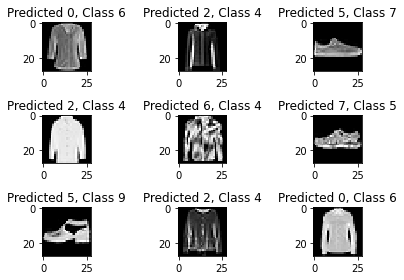

In [ ]:
predictions = np.argmax(np.round(predictions),axis=1)

classes = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

#plot random examples of incorrect predictions
incorrect = np.where(predictions!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predictions[incorrect], test_Y[incorrect]))
    plt.tight_layout()

In [ ]:
#create confusion matrix
cmat=pd.DataFrame(confusion_matrix(test_Y, predictions, normalize='true').round(2),index=classes.values(), columns=classes.values())

Text(-1.875, 0.5, 'True')

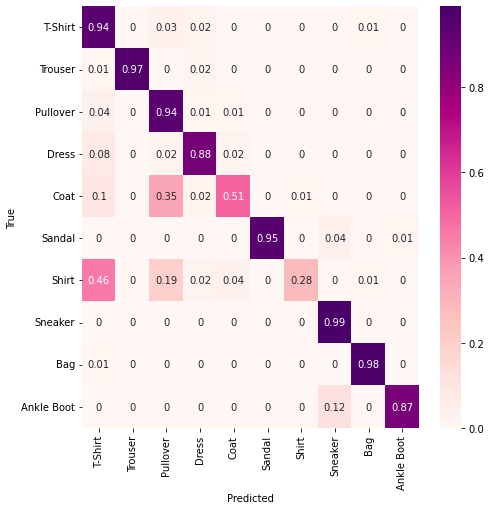

In [ ]:
from seaborn import heatmap
plt.figure(figsize=(7,7))
heatmap(cmat,annot=True,cmap='RdPu')
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')

# Report

The architecture of the model includes three convolution layers including a convolution filter, a max pooling filter, and an relu activation filter. The kernel sizes were 5x5, 4x4, and 3x3 respectively. After the convolution layers, a flatten layer and FC layer is added. Then, there is another activation layer and a dropout layer. Finally, a FC layer was added as the output layer.


The model ended up acheiving up to an 89% testing accuracy but in the end, only predicting 8,343 labels correct out of 10,000. As you can see from the confusion matrix, the label with the highest accuracy was sneaker and the one with the least was shirt where the model predicted a shirt was a t-shirt more than an actual shirt. It also struggled with differentiating between a coat and a pullover.

I chose to run the model with 10 epochs, a batch size of 64, and a dropout rate of 0.5.

It took around 40 minutes to train the model with 10 epochs which is way more than training a model using keras (around 2 minutes with 10 epochs).
